# Lab 7-1: Rating Curves

This is an exerpt from a lab from CEE 465: Data Analysis, which goes deeper into the statistics of rating curve calculations
(Put together by Steven Pestana, 2019 and Jessica Lundquist, years before 2019)

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import scipy.io as sio 

%matplotlib inline

---
#### Load in the provided data:
We're provided data in a .mat format (MATLAB's data file format). The ```scipy.io``` library has a function that allows us to read these types of files. Take a look at its documentation:

In [2]:
sio.loadmat?

Now load the Lyell canyon streamflow data:

In [2]:
data = sio.loadmat('../data/Lyell_h_Q_sorted.mat')
# Note, if you have copied the .mat file into your current directory, comment out the line above and use the one below instead
# data = sio.loadmat('Lyell_h_Q_sorted.mat') 

What kind of data structure is our data in?

In [3]:
type(data)

dict

This is a dictionary. [Read more about python dictionaries here](https://docs.python.org/3.8/tutorial/datastructures.html#dictionaries).

In [4]:
# See what our data looks like in a dictionary data structure
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Tue Nov  3 14:17:54 2015',
 '__version__': '1.0',
 '__globals__': [],
 'h1': array([[0.1805],
        [0.2197],
        [0.2406],
        [0.2407],
        [0.2565],
        [0.2822],
        [0.285 ],
        [0.2904],
        [0.2907],
        [0.2907],
        [0.2925],
        [0.3066],
        [0.3185],
        [0.3227],
        [0.3405],
        [0.3492],
        [0.3648],
        [0.3668],
        [0.3757],
        [0.3781],
        [0.3814],
        [0.383 ],
        [0.3913],
        [0.3913],
        [0.4006],
        [0.408 ],
        [0.4319],
        [0.4957],
        [0.4982],
        [0.5227],
        [0.5325],
        [0.5391],
        [0.5427],
        [0.5638],
        [0.571 ],
        [0.573 ],
        [0.6096],
        [0.6144],
        [0.6358],
        [0.6372],
        [0.6437],
        [0.644 ],
        [0.673 ],
        [0.6753],
        [0.6757],
        [0.6825],
        [0.6873],
        [0

In [3]:
# Inspect the dictionary keys
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'h1', 'Qobs1', 'date_of_obs'])

We can convert this dictionary into a pandas dataframe and select only the columns of data that we want (ignoring the file metadata):
(Even though we know, that in cases outside of the classroom, people only ignore metadata at their own peril.)

In [3]:
df = pd.DataFrame(np.hstack((data['date_of_obs'], data['h1'], data['Qobs1'])),
                  columns=['date_of_obs','h1', 'Qobs1'])
df.head()

date_of_obs      h1     Qobs1
0  [9/26/08 16:30]  0.1805   0.07786
1   [9/19/08 0:02]  0.2197  0.071914
2  [9/10/08 21:35]  0.2406  0.143829
3  [9/10/10 17:52]  0.2407  0.168177
4  [8/20/07 18:22]  0.2565  0.243489

And make sure our ```date_of_obs``` is being interpreted as a datetime correctly (see documentation [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html) and [here](http://strftime.org/)):

In [4]:
df['date_of_obs'] = [pd.to_datetime(dt[0], format='%m/%d/%y %H:%M') for dt in df['date_of_obs']]

In [5]:
df.head()

date_of_obs      h1     Qobs1
0 2008-09-26 16:30:00  0.1805   0.07786
1 2008-09-19 00:02:00  0.2197  0.071914
2 2008-09-10 21:35:00  0.2406  0.143829
3 2010-09-10 17:52:00  0.2407  0.168177
4 2007-08-20 18:22:00  0.2565  0.243489

### Calculating rating curves

At stream gauges all over the world, we measure a timeseries of water height at a fixed point, and we generally develop an empirical rating curve to determine discharge, which is volume of flow per unit time, in units of of $m^3/s$ (cubic meters per second or cms) or $ft^3/s$ (cubic feet per second of cfs).

In developing this rating curve, we are trying to solve for a, b, and c in the equation
$Q = a(h-b)^c$

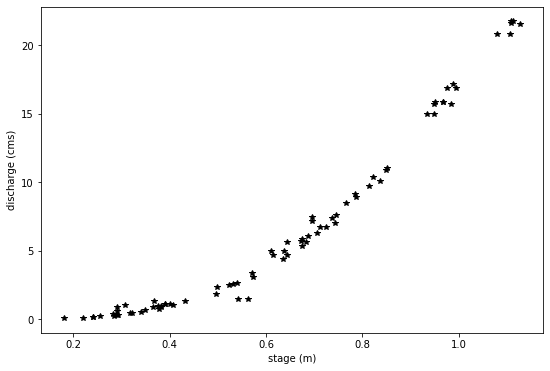

In [6]:
# First, let's plot all of the data we just read in.
plt.figure(figsize=(9,6))

plt.xlabel('stage (m)')
plt.ylabel('discharge (cms)')
plt.plot(df.h1,df.Qobs1,'k*')

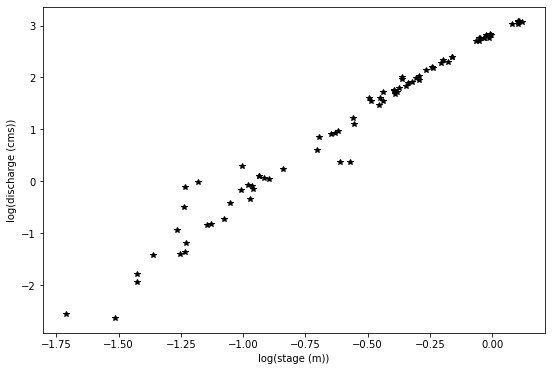

In [7]:
#And plot the log transform of both variables
loght=np.log(df.h1.astype('float'))
logQ=np.log(df.Qobs1.astype('float'))

plt.figure(figsize=(9,6))

plt.xlabel('log(stage (m))')
plt.ylabel('log(discharge (cms))')
plt.plot(loght,logQ,'k*')

### Inspect the data
You can see above that even with a log transform, the data do not fall on a straight line.  If I squint at the graph above, I can imagine two lines through this data, with a break about midway through the data.

At this point, it's a good idea to look at your field site and see what physical evidence there is that the rating curve might have a break point.  

![Lyell Fork Tuolumne Plot](LyellFork_Tuolumne_flowcontrol.png)

You can see from the photo above (and from the lecture notes), that at certain flow levels, this river stretch switches from being channel controlled to having a bedrock control, like a weir.  From Open Channel Flow class (and from the lecture notes), we know that this changes the exponent in the stage-discharge equation, which would change the slope of our line here.

For simplicity, we will consider only the upper end of the rating curve, focusing on flows that are high enough to not be influenced by the pictured bedrock control.

---
### PART 1: Linear Regression of Transformed Variables:  
As illustrated above, due to the nature of our channel, we would need to separate our variables and fit two lines to it.  For simplicity, we will focus here on the upper portion of the rating curve, looking only at higher flows.  Work by CEE M.S. student Gwyn Perry, the transition between the two slopes is about 0.54.  I also want to ignore two outlier measurements right around this transition, so I choose to look at data above a stage height of 0.59.  You can change this cut-off value and see how it changes the results.  Ideally, we would have a survey of the location that identifies the exact stage when the bedrock control becomes dominant.

In [8]:
# Define a level where the transition occurs, where you need different rating curve coefficients.
h11 = 0.59

First, we identify the rows in our data frame that correspond to flows with h1 > h11, these correspond to data above the change in channel control.

In [9]:
Qobs_now = df.Qobs1[df.h1 > h11]
h_now = df.h1[df.h1 > h11]

In developing this rating curve, we are trying to solve for a, b, and c in the equation
$Q = a(h-b)^c$

When we take the log of both sides, we get
$log(Q) = log(a) + c*log(h-b)$
Note that we can use linear regression to solve for $log(a)$ -- this would be $B0$ in earlier code -- and for $c$ -- this would be $B1$ in earlier code.  Note that we cannot directly solve for $b$.  We have to guess $b$ (based on observations in the field or an iterative technique).

In [10]:
# based on field measurements, we know b must be between 10 and 50 cm, 
# which is the same as 0.1 to 0.5 meters.  
# We start with a guess.
b=0.28
# and we subtract this value off of the measured stream height
hobs_minusb=h_now.subtract(b)
print(hobs_minusb)

36    0.3296
37    0.3344
38    0.3558
39    0.3572
40    0.3637
41     0.364
42     0.393
43    0.3953
44    0.3957
45    0.4025
46    0.4073
47     0.416
48     0.416
49    0.4261
50     0.432
51     0.444
52    0.4569
53    0.4643
54     0.465
55    0.4857
56     0.504
57    0.5068
58    0.5342
59    0.5414
60     0.556
61    0.5697
62    0.5715
63    0.6554
64    0.6685
65    0.6691
66    0.6703
67     0.687
68    0.6881
69    0.6952
70    0.7049
71     0.709
72     0.714
73    0.8006
74    0.8274
75     0.829
76     0.829
77    0.8334
78    0.8481
Name: h1, dtype: object


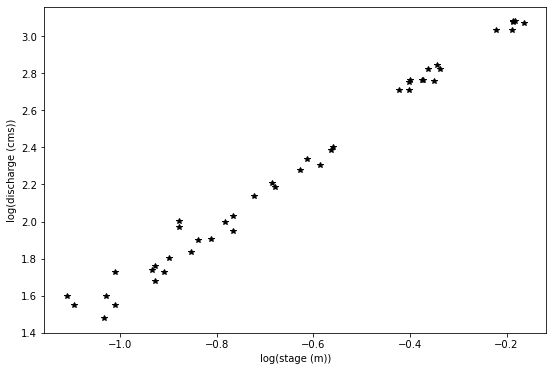

In [11]:
#And plot the log transform of both variables
loght=np.log(hobs_minusb.astype('float'))
# note that the above is taking the log of the observed values minus b
logQ=np.log(Qobs_now.astype('float'))

plt.figure(figsize=(9,6))

plt.xlabel('log(stage (m))')
plt.ylabel('log(discharge (cms))')
plt.plot(loght,logQ,'k*')

With linear regression, we can only solve for two of the three unknowns in our rating curve equation:
$Q = a(h-b)^c$
which we have log transformed to be
$log(Q) = log(a) + c*log(h-b)$

First, we will assume that b is 0.28 m, as we entered above.   In practice, this is often estimated from field surveys as the maximum height of water in the measuring pool when flow stops.

We then use the same code from basic linear regresssion (Lab 4.3 in CEE 465: Data Analysis), where our calculated slope will be c, and our calculated intercept will be log(a).

In [12]:
x=loght
# Note that our x value here includes the log of our measured stage minus b (see above)
y=logQ
n = len(x)

B1 = ( n*np.sum(x*y) - np.sum(x)*np.sum(y) ) / ( n*np.sum(x**2) - np.sum(x)**2 ) # B1 parameter, slope
B0 = np.mean(y) - B1*np.mean(x) # B0 parameter, y-intercept

print('B0 : {}'.format(np.round(B0,4)))
print('B1 : {}'.format(np.round(B1,4)))

B0 : 3.4077
B1 : 1.7662


Just to clarify what we have here.  $B0 = log(a)$ and $B1 = c$ and $x = log(h-b)$.  If we want to revert to our original equation, we solve for $a = exp(B0)$ and $c = B1$ and $h = exp(x) + b$ 

In [13]:
# Now, how do we find 95% confidence intervals?  We do this for our estimates of logQ
# Again, borrowing from Lab 4.3
y_predicted = B0 + B1*x
residuals = (y - y_predicted)
# sum of squared errors
sse = np.sum(residuals**2)
# standard error of regression
s = np.sqrt(sse/(n-2))

# create an array of x values
p_x = np.linspace(x.min(),x.max(),100)

# using our model parameters to predict y values
p_y = B0 + B1*p_x

# calculate the standard error of the predictions
sigma_ep = np.sqrt( s**2 * (1 + 1/n + ( ( n*(p_x-x.mean())**2 ) / ( n*np.sum(x**2) - np.sum(x)**2 ) ) ) )

# our chosen alpha
alpha = 0.05

# compute our degrees of freedom with the length of the predicted dataset
n = len(p_x)
dof = n - 2

# get the t-value for our alpha and degrees of freedom
t = st.t.ppf(1-alpha/2, dof)

# compute the upper and lower limits at each of the p_x values
p_y_lower = p_y - t * sigma_ep
p_y_upper = p_y + t * sigma_ep

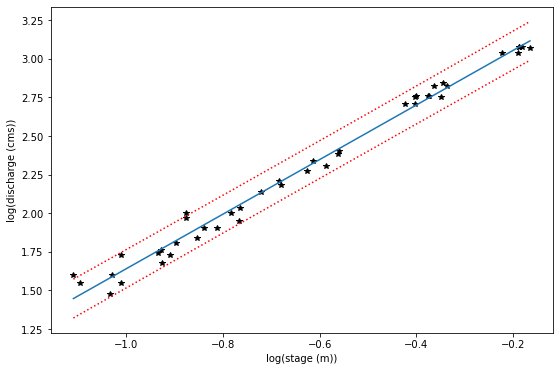

In [14]:
# First let's make a plot in the log-transformed space
plt.figure(figsize=(9,6))

plt.xlabel('log(stage (m))')
plt.ylabel('log(discharge (cms))')
plt.plot(loght,logQ,'k*')
plt.plot(p_x,p_y)
plt.plot(p_x,p_y_lower,':r')
plt.plot(p_x,p_y_upper,':r')

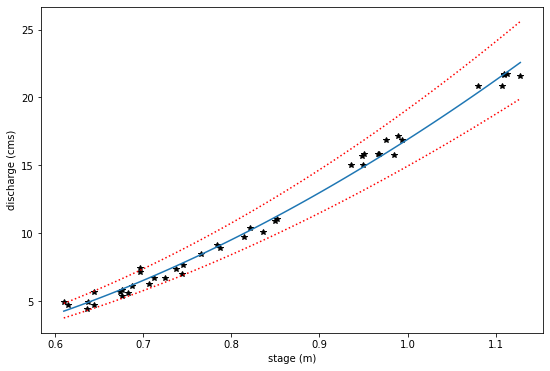

In [15]:
# Now we transform each piece back into the original form
Q_predict=np.exp(p_y)
Q_predict_upper=np.exp(p_y_upper)
Q_predict_lower=np.exp(p_y_lower)
x_topredict=np.exp(p_x) + b
# Plot the original data and then the prediction lines
plt.figure(figsize=(9,6))

plt.xlabel('stage (m)')
plt.ylabel('discharge (cms)')
plt.plot(h_now,Qobs_now,'k*')
plt.plot(x_topredict,Q_predict)
plt.plot(x_topredict,Q_predict_lower,':r')
plt.plot(x_topredict,Q_predict_upper,':r')